# What's in this notebook
Our initial manual testing process of the different sentiment models, using a random sample of speeches manually labelled positive, negative, neutral.

# Libraries

In [561]:
import os
import re
import string
import pickle
from collections import defaultdict
from datetime import datetime

# DP
import numpy as np
import pandas as pd
import scipy

# Visualisation
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# NLP
import nltk
from nltk.corpus import stopwords, words, wordnet as wn
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import pos_tag
from nltk.tokenize import sent_tokenize
import contractions
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Other
import gdown
import torch
from IPython.display import Image
import pickle
import openai
import time
import anthropic

# Summary of conclusions

**VADER, TextBlob, Adapted LM Dictionary provided by BoE, FinBERT, Central Bank RoBERTa, Chat GPT, and Claude** have been tested against a sample of manually labelled (positive, negative, neutral) speeches. The below outlines the results.
#### 
**SUMMARY OF FINDINGS**
- **VADER** and **TextBlob** (general-purpose models) perform the worst and can be disregarded.
- The financial models **LM Dictionary** (lexicon-based) and **FinBERT** (ML transformer model) perform better.
- **Central Bank RoBERTa** (ML transformer model trained on central-bank comms) performs the best of the financial models.
- **Chat GPT** (Generative LLM) performs better than Central Bank RoBERTa due to its correct prediction of neutral speeches (Central Bank RoBERTa has a more negative skew). **Claude** does not perform as well an can be disregar#### ded.

**LIMITATIONS**
- **Manual-labelling challenges:** Speeches are long and complex, covering differnet topics and outlooks, and labelling them is a subjective exercise.
- **Threshold differences:** We used each model's different norms for determining a sentiment label to avoid overfitting to our test data. These different approaches (e.g. argmax vs. threshhold) makes direct comparison inherently imperfect.

#### Testing results (copied from bottom of this notebook)

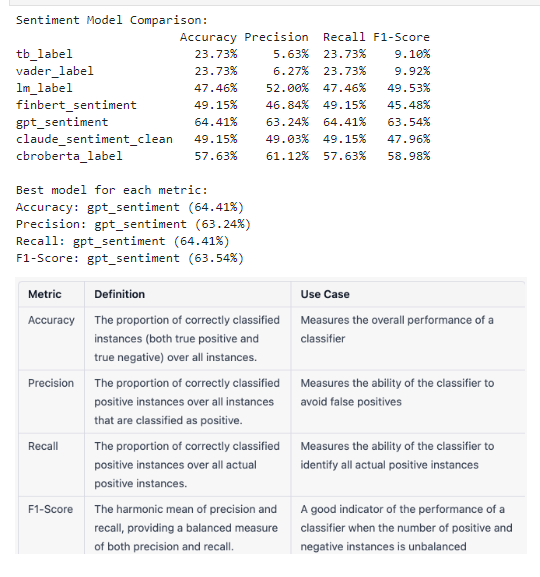

In [563]:
Image('Images/model_comparison.png')

# Testing functions

In [1]:
def metrics(df, col_name, model_name):
    ''' Function to view predicted sentiment breakdown,
    calculate/show accuracy metrics. Optional crosstab of results (to verity heatmap labels)'''
    
    print(f"{model_name} Results:")
    print()

    # View predicted sentiment breakdown
    print("Predicted Sentiment Breakdown:")
    print(df[col_name].value_counts(normalize=True).map(lambda x: f"{x:.2%}"))
    print()
    print('-'*50)
    print()
    
    # Calculate accuracy metrics
    accuracy = accuracy_score(df['sentiment_labelled'], df[col_name])
    precision = precision_score(df['sentiment_labelled'], df[col_name], average='weighted', zero_division=0)
    recall = recall_score(df['sentiment_labelled'], df[col_name], average='weighted', zero_division=0)
    f1 = f1_score(df['sentiment_labelled'], df[col_name], average='weighted')

    # Display results
    print("Metrics:")
    print(f"Accuracy: {accuracy:.2%}")
    print(f"Precision: {precision:.2%}")
    print(f"Recall: {recall:.2%}")
    print(f"F1-Score: {f1:.2%}")
    print()
    print('-'*50)
    print()

    # Create a crosstab to see how they align
    # crosstab = pd.crosstab(df['sentiment_labelled'], 
            # df[col_name], 
            # rownames=['Manual'], 
            # colnames=[model_name])
    # print('Crosstab of Predicted vs. Manual Labels:')
    # return crosstab

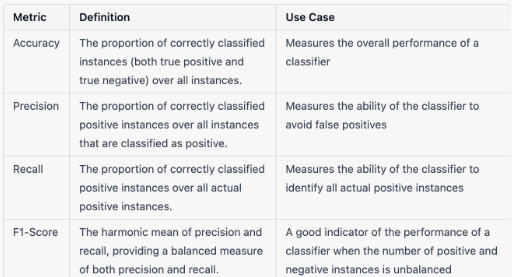

In [554]:
def confusion(df, col_name, model_name, savefig=None):
    ''' Create and plot confusion matrix of predicted vs. manually labelled results.'''

    # Create confusion matrix
    cm = confusion_matrix(df['sentiment_labelled'], df[col_name])

    # PLot confusion matrix
    cm_heat = sns.heatmap(cm, cmap='Purples', cbar=False, annot=True)

    # Create labels and title
    plt.xticks(np.arange(3) + 0.5, ['Negative', 'Neutral', 'Positive'])
    plt.yticks(np.arange(3) + 0.5, ['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted', fontsize=12, weight='bold')
    plt.ylabel('Manual', fontsize=12, weight='bold')
    plt.title(f'{model_name} Confusion Matrix', size=16)

    if savefig is not None:
        plt.savefig(savefig, dpi=300)
    
    plt.show()

# Data import

In [312]:
# https://docs.google.com/spreadsheets/d/1D0Ou2yIMwetGg8rnFRveuDcoJMckSVgWsq9wj0onL0E/edit?usp=drive_link
file_id = '1D0Ou2yIMwetGg8rnFRveuDcoJMckSVgWsq9wj0onL0E'
# Create the direct download link
download_url = f"https://drive.google.com/uc?id={file_id}"
# Download the file locally
output_path = 'testing_data.xlsx'  
gdown.download(download_url, output_path, quiet=False)
# Read the downloaded file 
df = pd.read_excel(output_path)

Downloading...
From (original): https://drive.google.com/uc?id=1D0Ou2yIMwetGg8rnFRveuDcoJMckSVgWsq9wj0onL0E
From (redirected): https://docs.google.com/spreadsheets/d/1D0Ou2yIMwetGg8rnFRveuDcoJMckSVgWsq9wj0onL0E/export?format=xlsx
To: C:\Users\katej\Desktop\LSE Data Analytics\4. Employer Project\BoE-Beacon\testing_data.xlsx
480kB [00:00, 1.27MB/s]


In [313]:
df.head()

,unique_id,date,author,is_gov,assigned_to,sentiment_labelled,hawk_dove_labelled,text
0,1086,2020-10-21,ramsden,0,Chris,Neutral,Dovish,It's a pleasure to be speaking once again at t...
1,932,2018-06-13,kashyap,0,Chris,Neutral,Neutral,Thanks for the invitation. I know many of my c...
2,278,2007-07-24,John Gieve,0,Chris,Positive,Hawkish,"When I took on this job last year, interest ra..."
3,901,2017-12-07,gracie,0,Chris,Neutral,Neutral,Resolution has come a long way since G20 Leade...
4,939,2018-07-05,Mark Carney,1,Chris,Positive,Hawkish,It is a great pleasure to join the Great Exhib...


In [314]:
# View relationship between hawkish/dovish and positive/negative labelling
pd.crosstab(df['sentiment_labelled'], df['hawk_dove_labelled'])

hawk_dove_labelled,Dovish,Hawkish,Neutral
sentiment_labelled,,,
Negative,4,3,2
Neutral,9,7,10
Positive,2,4,5


**Note:** We tagged hawkish/dovish stance as well in case we found a model that could measure this directly. However, we did not end up using this. 

In [315]:
# Subset needed cols
test_data = df[['unique_id', 'sentiment_labelled', 'text']].copy()
test_data.head()

,unique_id,sentiment_labelled,text
0,1086,Neutral,It's a pleasure to be speaking once again at t...
1,932,Neutral,Thanks for the invitation. I know many of my c...
2,278,Positive,"When I took on this job last year, interest ra..."
3,901,Neutral,Resolution has come a long way since G20 Leade...
4,939,Positive,It is a great pleasure to join the Great Exhib...


In [316]:
test_data['sentiment_labelled'].value_counts(normalize=True).map(lambda x: f"{x:.2%}")

sentiment_labelled
Neutral     59.32%
Positive    23.73%
Negative    16.95%
Name: proportion, dtype: object

# Text Prep

In [318]:
# Cleaning function
def preprocess_text(text):
    text = contractions.fix(text)  # Expand contractions i.e I'm not good goes to I am not good
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub('#', '', text)         # Remove hashtags
    text = re.sub(r'\W', ' ', text)      # Remove special characters
    text = text.lower()                  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text)  # Collapse extra whitespace
    # Set stop words with negation
    stop_words = set(stopwords.words('english')) - {'not'} 
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text.strip()

In [319]:
test_data['clean_text'] = test_data['text'].apply(preprocess_text)
test_data.head()

,unique_id,sentiment_labelled,text,clean_text
0,1086,Neutral,It's a pleasure to be speaking once again at t...,pleasure speaking society professional economi...
1,932,Neutral,Thanks for the invitation. I know many of my c...,thanks invitation know many colleagues previou...
2,278,Positive,"When I took on this job last year, interest ra...",took job last year interest rates moved twice ...
3,901,Neutral,Resolution has come a long way since G20 Leade...,resolution come long way since g20 leaders put...
4,939,Positive,It is a great pleasure to join the Great Exhib...,great pleasure join great exhibition north sma...


In [320]:
# Tokenise
test_data['tokens'] = test_data['clean_text'].apply(word_tokenize)
test_data.head()

,unique_id,sentiment_labelled,text,clean_text,tokens
0,1086,Neutral,It's a pleasure to be speaking once again at t...,pleasure speaking society professional economi...,"[pleasure, speaking, society, professional, ec..."
1,932,Neutral,Thanks for the invitation. I know many of my c...,thanks invitation know many colleagues previou...,"[thanks, invitation, know, many, colleagues, p..."
2,278,Positive,"When I took on this job last year, interest ra...",took job last year interest rates moved twice ...,"[took, job, last, year, interest, rates, moved..."
3,901,Neutral,Resolution has come a long way since G20 Leade...,resolution come long way since g20 leaders put...,"[resolution, come, long, way, since, g20, lead..."
4,939,Positive,It is a great pleasure to join the Great Exhib...,great pleasure join great exhibition north sma...,"[great, pleasure, join, great, exhibition, nor..."


In [321]:
# Simple clean function for FinBERT and VADER
def simple_clean(text):
    text = contractions.fix(text)  # Expand contractions i.e I'm not good goes to I am not good
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'\s+', ' ', text)  # Collapse extra whitespace
    return text.strip()

In [322]:
test_data['simple_clean'] = test_data['text'].apply(simple_clean)
test_data.head()

,unique_id,sentiment_labelled,text,clean_text,tokens,simple_clean
0,1086,Neutral,It's a pleasure to be speaking once again at t...,pleasure speaking society professional economi...,"[pleasure, speaking, society, professional, ec...",It is a pleasure to be speaking once again at ...
1,932,Neutral,Thanks for the invitation. I know many of my c...,thanks invitation know many colleagues previou...,"[thanks, invitation, know, many, colleagues, p...",Thanks for the invitation. I know many of my c...
2,278,Positive,"When I took on this job last year, interest ra...",took job last year interest rates moved twice ...,"[took, job, last, year, interest, rates, moved...","When I took on this job last year, interest ra..."
3,901,Neutral,Resolution has come a long way since G20 Leade...,resolution come long way since g20 leaders put...,"[resolution, come, long, way, since, g20, lead...",Resolution has come a long way since G20 Leade...
4,939,Positive,It is a great pleasure to join the Great Exhib...,great pleasure join great exhibition north sma...,"[great, pleasure, join, great, exhibition, nor...",It is a great pleasure to join the Great Exhib...


# TextBlob

In [324]:
# TextBlob functions for polarity and subjectivity
def tb_polarity(comment):
    '''Extract polarity score (-1 to +1) for each comment'''
    return TextBlob(comment).sentiment[0]

In [325]:
test_data['tb_score'] = test_data['clean_text'].apply(tb_polarity)

# Generate polarity groupings
test_data['tb_label']=''
test_data.loc[test_data.tb_score > 0,'tb_label']='Positive'
test_data.loc[test_data.tb_score == 0,'tb_label']='Neutral'
test_data.loc[test_data.tb_score < 0,'tb_label']='Negative'

test_data.sample(3)

,unique_id,sentiment_labelled,text,clean_text,tokens,simple_clean,tb_score,tb_label
1,932,Neutral,Thanks for the invitation. I know many of my c...,thanks invitation know many colleagues previou...,"[thanks, invitation, know, many, colleagues, p...",Thanks for the invitation. I know many of my c...,0.085038,Positive
16,79,Negative,No country is an island - in terms of economic...,country island terms economics not geography t...,"[country, island, terms, economics, not, geogr...",No country is an island - in terms of economic...,0.094477,Positive
22,1101,Neutral,Good afternoon and thanks for having me. It is...,good afternoon thanks pleasure give speech vir...,"[good, afternoon, thanks, pleasure, give, spee...",Good afternoon and thanks for having me. It is...,0.028836,Positive


### TextBlob Accuracy

In [327]:
# Run metrics
metrics(test_data, 'tb_label', 'TextBlob')

TextBlob Results:

Predicted Sentiment Breakdown:
tb_label
Positive    100.00%
Name: proportion, dtype: object

--------------------------------------------------

Metrics:
Accuracy: 23.73%
Precision: 5.63%
Recall: 23.73%
F1-Score: 9.10%

--------------------------------------------------



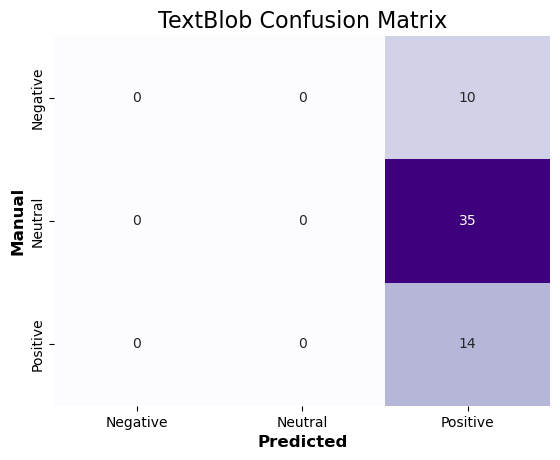

In [580]:
# Return confusion matrix
confusion(test_data, 'tb_label', 'TextBlob')

**Observation:** TextBlob skews far too positive at accepted threshholds. Not appropriate for this task.

# VADER

In [331]:
analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    # Check if text is a list or string
    if isinstance(text, list):
        joined_text = ' '.join(text)
    else:
        joined_text = text
    return analyzer.polarity_scores(joined_text)

In [332]:
# Apply function and create new columns 
sentiment_scores = test_data['simple_clean'].apply(vader_sentiment)
test_data['neg'] = sentiment_scores.apply(lambda x: x['neg'])
test_data['neu'] = sentiment_scores.apply(lambda x: x['neu'])
test_data['pos'] = sentiment_scores.apply(lambda x: x['pos'])
test_data['compound'] = sentiment_scores.apply(lambda x: x['compound'])

# Add VADER sentiment groupings 
test_data['vader_label'] = ''
test_data.loc[test_data.compound >= 0.05, 'vader_label'] = 'Positive'
test_data.loc[(test_data.compound > -0.05) & (test_data.compound < 0.05), 'vader_label'] = 'Neutral'
test_data.loc[test_data.compound <= -0.05, 'vader_label'] = 'Negative'

test_data.head()

,unique_id,sentiment_labelled,text,clean_text,tokens,simple_clean,tb_score,tb_label,neg,neu,pos,compound,vader_label
0,1086,Neutral,It's a pleasure to be speaking once again at t...,pleasure speaking society professional economi...,"[pleasure, speaking, society, professional, ec...",It is a pleasure to be speaking once again at ...,0.125389,Positive,0.074,0.825,0.100,0.9984,Positive
1,932,Neutral,Thanks for the invitation. I know many of my c...,thanks invitation know many colleagues previou...,"[thanks, invitation, know, many, colleagues, p...",Thanks for the invitation. I know many of my c...,0.085038,Positive,0.083,0.825,0.092,0.9759,Positive
2,278,Positive,"When I took on this job last year, interest ra...",took job last year interest rates moved twice ...,"[took, job, last, year, interest, rates, moved...","When I took on this job last year, interest ra...",0.046656,Positive,0.070,0.804,0.126,0.9998,Positive
3,901,Neutral,Resolution has come a long way since G20 Leade...,resolution come long way since g20 leaders put...,"[resolution, come, long, way, since, g20, lead...",Resolution has come a long way since G20 Leade...,0.076115,Positive,0.066,0.835,0.099,0.9983,Positive
4,939,Positive,It is a great pleasure to join the Great Exhib...,great pleasure join great exhibition north sma...,"[great, pleasure, join, great, exhibition, nor...",It is a great pleasure to join the Great Exhib...,0.083778,Positive,0.062,0.811,0.127,0.9998,Positive


## VADER accuracy

In [334]:
metrics(test_data, 'vader_label', 'VADER')

VADER Results:

Predicted Sentiment Breakdown:
vader_label
Positive    89.83%
Negative    10.17%
Name: proportion, dtype: object

--------------------------------------------------

Metrics:
Accuracy: 23.73%
Precision: 6.27%
Recall: 23.73%
F1-Score: 9.92%

--------------------------------------------------



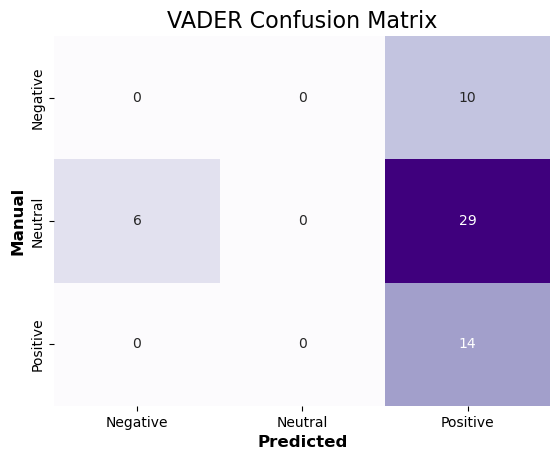

In [582]:
confusion(test_data, 'vader_label', 'VADER')

**Observation:** A far too positive skew. This consistent finding with TextBlob strengthens the theory that our testing is useful and that general-purpose models are not appropriate here.

# LM

In [338]:
# Load BoE Wordlist
wordlist = pd.read_csv('../Data/boe_wordlist.csv')

In [339]:
# Convert words to lowercase
wordlist['Word'] = wordlist['Word'].str.lower()
wordlist.head()

,Word,Negative,Positive,Uncertainty,Litigious,Strong,Weak,Constraining
0,abandon,1,0,0,0,0,0,0
1,abandoned,1,0,0,0,0,0,0
2,abandoning,1,0,0,0,0,0,0
3,abandonment,1,0,0,0,0,0,0
4,abandonments,1,0,0,0,0,0,0


In [340]:
# Add columns for positive and negative
categories = ['Negative', 'Positive']

for cat in categories:
    word_set = set(wordlist[wordlist[cat] == 1]['Word']) 
    col_name = f'lm_n_{cat.lower()}' 
    test_data[col_name] = test_data['tokens'].apply(lambda x: sum(word in word_set for word in x)) # Count words in each speech

In [341]:
test_data.sample(3)

,unique_id,sentiment_labelled,text,clean_text,tokens,simple_clean,tb_score,tb_label,neg,neu,pos,compound,vader_label,lm_n_negative,lm_n_positive
11,416,Neutral,Speech by I am very pleased to have been invit...,speech pleased invited speak year cato institu...,"[speech, pleased, invited, speak, year, cato, ...",Speech by I am very pleased to have been invit...,0.068989,Positive,0.056,0.800,0.144,0.9998,Positive,68,41
41,1211,Positive,Phil provides an overview of the approach in t...,phil provides overview approach pra consultati...,"[phil, provides, overview, approach, pra, cons...",Phil provides an overview of the approach in t...,0.089999,Positive,0.045,0.820,0.135,0.9999,Positive,48,60
10,68,Positive,I am delighted to be able to take part in this...,delighted able take part conference particular...,"[delighted, able, take, part, conference, part...",I am delighted to be able to take part in this...,0.136686,Positive,0.043,0.767,0.190,0.9999,Positive,29,69


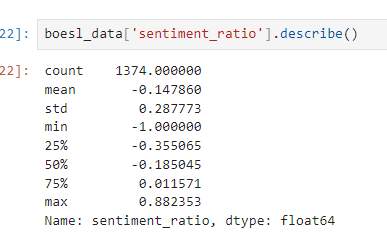

In [576]:
# Load image descriptive statistics from LM dictionary on full data set for guidance in creating thresholds 
# (from KJ_branch_sentiment_analysis notebook).
Image('Images/lm_describe.png', width=300)

In [343]:
# Apply scoring
''' 
These threshholds are based on the sentiment ratio quartiles from the entire data set 
(not in this notebook - see image above)
'''
pos_threshold = -0.07
neg_threshold = -0.35

test_data['sentiment_ratio'] = (test_data['lm_n_positive'] - test_data['lm_n_negative']) / (test_data['lm_n_positive'] + test_data['lm_n_negative'])  

test_data['lm_label'] = test_data['sentiment_ratio'].apply(
    lambda x: 'Positive' if x > pos_threshold else 'Negative' if x < neg_threshold else 'Neutral')

test_data.head(3)

,unique_id,sentiment_labelled,text,clean_text,tokens,simple_clean,tb_score,tb_label,neg,neu,pos,compound,vader_label,lm_n_negative,lm_n_positive,sentiment_ratio,lm_label
0,1086,Neutral,It's a pleasure to be speaking once again at t...,pleasure speaking society professional economi...,"[pleasure, speaking, society, professional, ec...",It is a pleasure to be speaking once again at ...,0.125389,Positive,0.074,0.825,0.100,0.9984,Positive,83,47,-0.276923,Neutral
1,932,Neutral,Thanks for the invitation. I know many of my c...,thanks invitation know many colleagues previou...,"[thanks, invitation, know, many, colleagues, p...",Thanks for the invitation. I know many of my c...,0.085038,Positive,0.083,0.825,0.092,0.9759,Positive,83,48,-0.267176,Neutral
2,278,Positive,"When I took on this job last year, interest ra...",took job last year interest rates moved twice ...,"[took, job, last, year, interest, rates, moved...","When I took on this job last year, interest ra...",0.046656,Positive,0.070,0.804,0.126,0.9998,Positive,94,72,-0.132530,Neutral


### LM accuracy

In [345]:
metrics(test_data, 'lm_label', 'BoE Adapted LM')

BoE Adapted LM Results:

Predicted Sentiment Breakdown:
lm_label
Neutral     52.54%
Negative    25.42%
Positive    22.03%
Name: proportion, dtype: object

--------------------------------------------------

Metrics:
Accuracy: 47.46%
Precision: 52.00%
Recall: 47.46%
F1-Score: 49.53%

--------------------------------------------------



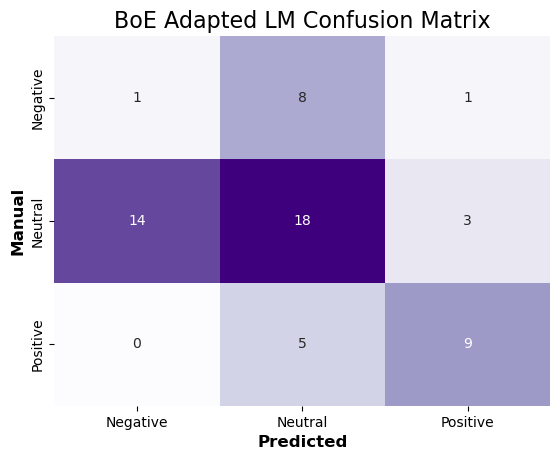

In [578]:
confusion(test_data, 'lm_label', 'BoE Adapted LM')

**Observation:** A much better result than the general-purpose models, though not stellar. Inconsistent patterns in the confusion matrix, predicting manually labelled negative speeches as neutral and manually labelled neutral speeches as negative.

# FinBERT

In [349]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [350]:
model.config.id2label

{0: 'positive', 1: 'negative', 2: 'neutral'}

In [351]:
def finbert_sentiment(text: str) -> tuple[float, float, float, str]:
    with torch.no_grad():
        inputs = tokenizer(
            text, return_tensors="pt", padding=True, truncation=True, max_length=512
        )
        outputs = model(**inputs)
        logits = outputs.logits
        scores = {
            k: v
            for k, v in zip(
                model.config.id2label.values(),
                scipy.special.softmax(logits.numpy().squeeze()),
            )
        }
        return (
            scores["positive"],
            scores["negative"],
            scores["neutral"],
            max(scores, key=scores.get),
        )

In [352]:
# Run on speech text
test_data[['finbert_pos', 'finbert_neg', "finbert_neu", "finbert_sentiment"]] = (
    test_data['simple_clean'].apply(finbert_sentiment).apply(pd.Series)
)
test_data["finbert_score"] = test_data["finbert_pos"] - test_data["finbert_neg"]
test_data.sample(3)

,unique_id,sentiment_labelled,text,clean_text,tokens,simple_clean,tb_score,tb_label,neg,neu,...,vader_label,lm_n_negative,lm_n_positive,sentiment_ratio,lm_label,finbert_pos,finbert_neg,finbert_neu,finbert_sentiment,finbert_score
53,1064,Neutral,Thanks Erik and thanks very much for inviting ...,thanks erik thanks much inviting webinar talk ...,"[thanks, erik, thanks, much, inviting, webinar...",Thanks Erik and thanks very much for inviting ...,0.089799,Positive,0.052,0.836,...,Positive,43,33,-0.131579,Neutral,0.175149,0.125992,0.698860,neutral,0.049157
34,537,Neutral,All speeches are available online at It is a g...,speeches available online great pleasure edinb...,"[speeches, available, online, great, pleasure,...",All speeches are available online at It is a g...,0.053708,Positive,0.083,0.784,...,Positive,64,47,-0.153153,Neutral,0.064995,0.040462,0.894543,neutral,0.024533
55,1152,Neutral,Tony Wilson for their assistance in preparatio...,tony wilson assistance preparation event would...,"[tony, wilson, assistance, preparation, event,...",Tony Wilson for their assistance in preparatio...,0.053964,Positive,0.057,0.860,...,Positive,133,58,-0.392670,Negative,0.075642,0.086915,0.837443,neutral,-0.011274


In [353]:
# Convert labels to title case
test_data['finbert_sentiment'] = test_data['finbert_sentiment'].str.title()
test_data.sample(3)

,unique_id,sentiment_labelled,text,clean_text,tokens,simple_clean,tb_score,tb_label,neg,neu,...,vader_label,lm_n_negative,lm_n_positive,sentiment_ratio,lm_label,finbert_pos,finbert_neg,finbert_neu,finbert_sentiment,finbert_score
35,665,Neutral,On 13 October 2008 - just over 6 years ago - t...,13 october 2008 6 years ago uk government inje...,"[13, october, 2008, 6, years, ago, uk, governm...",On 13 October 2008 - just over 6 years ago - t...,0.048325,Positive,0.102,0.790,...,Positive,90,38,-0.406250,Negative,0.086684,0.588678,0.324638,Negative,-0.501994
48,683,Neutral,Thank you very much for inviting me here today...,thank much inviting today great pleasure talki...,"[thank, much, inviting, today, great, pleasure...",Thank you very much for inviting me here today...,0.058129,Positive,0.100,0.765,...,Positive,192,179,-0.035040,Positive,0.102850,0.508760,0.388390,Negative,-0.405909
21,395,Neutral,Thank you for inviting me to speak today. My o...,thank inviting speak today original title some...,"[thank, inviting, speak, today, original, titl...",Thank you for inviting me to speak today. My o...,0.049161,Positive,0.089,0.818,...,Negative,85,32,-0.452991,Negative,0.041238,0.056269,0.902492,Neutral,-0.015031


### FinBERT accuracy

In [355]:
metrics(test_data, 'finbert_sentiment', 'FinBERT')

FinBERT Results:

Predicted Sentiment Breakdown:
finbert_sentiment
Neutral     69.49%
Negative    25.42%
Positive     5.08%
Name: proportion, dtype: object

--------------------------------------------------

Metrics:
Accuracy: 49.15%
Precision: 46.84%
Recall: 49.15%
F1-Score: 45.48%

--------------------------------------------------



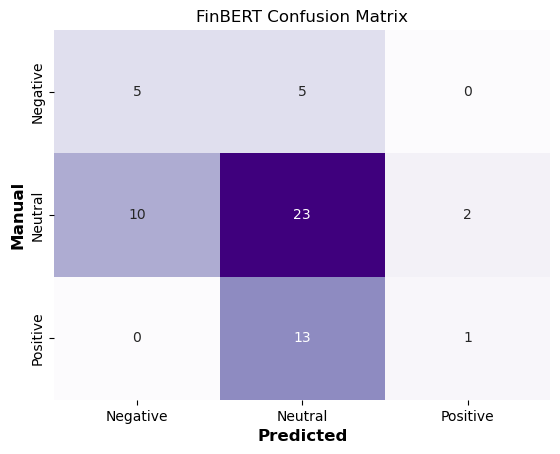

In [487]:
confusion(test_data, 'finbert_sentiment', 'FinBERT')

**Observation:** Similar metrics and confusion matrix results to LM. FinBERT has predicted far more speeches as neutral - perhaps due to norm of using 

# Central Bank RoBERTa

### Import and manage DataFrames

In [360]:
# Load file - pivoted data set
# https://drive.google.com/file/d/169Y9_hsVRjcwfS5bJcN7cGG5hqbzSEJ9/view?usp=drive_link
# agent_sentiment_pivot.csv
file_id = '169Y9_hsVRjcwfS5bJcN7cGG5hqbzSEJ9'
# Create the direct download link
download_url = f"https://drive.google.com/uc?id={file_id}"
# Download the file locally
output_path = 'agent_sentiment_pivot_local.csv' 
gdown.download(download_url, output_path, quiet=False)
# Read the downloaded file 
agent_sentiment_pivot = pd.read_csv(output_path)

Downloading...
From: https://drive.google.com/uc?id=169Y9_hsVRjcwfS5bJcN7cGG5hqbzSEJ9
To: C:\Users\katej\Desktop\LSE Data Analytics\4. Employer Project\BoE-Beacon\agent_sentiment_pivot_local.csv
100%|██████████| 30.9M/30.9M [00:01<00:00, 28.8MB/s]


In [361]:
print(agent_sentiment_pivot.shape)
agent_sentiment_pivot.head()

(1365, 12)


,custom_ref,date,author,is_gov,central_bank,financial_sector,firms,government,households,cbroberta_avg_score,cbroberta_avg_sentiment,text
0,UK_1998-09-15_George,1998-09-15,Edward George,1,-0.409745,-0.661564,-0.202167,-0.518037,-0.042013,-0.295018,0,"Thank you, Chairman. I'm actually very pleased..."
1,UK_1998-10-21_George,1998-10-21,Edward George,1,-0.134019,0.047685,-0.305432,-0.251951,-0.535169,-0.128637,0,It's a great pleasure to be here in the beauti...
2,UK_1998-10-21_King,1998-10-21,Mervyn King,0,-0.516879,-0.644094,-0.581463,-0.580222,-0.672911,-0.601670,0,Few industries have suffered more from volatil...
3,UK_1998-11-01_budd,1998-11-01,budd,0,-0.497668,-0.373081,-0.598642,-0.567226,-0.360106,-0.476216,0,My topic this evening is the use of forecasts ...
4,UK_1998-11-01_vickers,1998-11-01,vickers,0,-0.555400,-0.629627,-0.683497,-0.339261,-0.289324,-0.569214,0,"Six years ago this week, sterling left the exc..."


In [362]:
# https://drive.google.com/file/d/1aikSt2GFcShr-8YRnlWbkkzTUZmwuyUD/view?usp=drive_link 
# Master Data set uk_speeches_cleaned_v2 13/05/25
file_id = '1aikSt2GFcShr-8YRnlWbkkzTUZmwuyUD'

# Create the direct download link
download_url = f"https://drive.google.com/uc?id={file_id}"

# Download the file locally
output_path = 'uk_speeches_cleaned_v2_local.csv'
gdown.download(download_url, output_path, quiet=False)

# Read the downloaded CSV
uk_data = pd.read_csv(output_path)

Downloading...
From: https://drive.google.com/uc?id=1aikSt2GFcShr-8YRnlWbkkzTUZmwuyUD
To: C:\Users\katej\Desktop\LSE Data Analytics\4. Employer Project\BoE-Beacon\uk_speeches_cleaned_v2_local.csv
100%|██████████| 30.9M/30.9M [00:01<00:00, 21.3MB/s]


In [363]:
uk_data.head()

,custom_ref,reference,country,date,title,author,is_gov,text
0,UK_1998-09-15_George,r980915a_BOE,UK,1998-09-15,Speech,Edward George,1.0,"Thank you, Chairman. I'm actually very pleased..."
1,UK_1998-10-21_George,r981021b_BOE,UK,1998-10-21,Britain in Europe,Edward George,1.0,It's a great pleasure to be here in the beauti...
2,UK_1998-10-21_King,r981021a_BOE,UK,1998-10-21,Impact of the recent turbulence in internation...,Mervyn King,0.0,Few industries have suffered more from volatil...
3,UK_1998-11-01_budd,r981101a_BOE,UK,1998-11-01,"Economic policy, with and without forecasts",budd,0.0,My topic this evening is the use of forecasts ...
4,UK_1998-11-01_vickers,r981101b_BOE,UK,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0.0,"Six years ago this week, sterling left the exc..."


In [364]:
ref_join = uk_data[['custom_ref', 'date', 'text']]
ref_join

,custom_ref,date,text
0,UK_1998-09-15_George,1998-09-15,"Thank you, Chairman. I'm actually very pleased..."
1,UK_1998-10-21_George,1998-10-21,It's a great pleasure to be here in the beauti...
2,UK_1998-10-21_King,1998-10-21,Few industries have suffered more from volatil...
3,UK_1998-11-01_budd,1998-11-01,My topic this evening is the use of forecasts ...
4,UK_1998-11-01_vickers,1998-11-01,"Six years ago this week, sterling left the exc..."
...,...,...,...
1360,UK_2025-02-28_Ramsden,2025-02-28,Speech Thank you for the invitation to speak ...
1361,UK_2025-03-03_Kyei,2025-03-03,"Speech Good evening everyone, students and al..."
1362,UK_2025-03-06_Mann,2025-03-06,Speech Introduction It is particularly fitti...
1363,UK_2025-03-24_Bailey,2025-03-24,Speech Thank you for inviting me to speak tod...


In [365]:
# Merge attempt
test_try = test_data.merge(ref_join, on='text', how='left')
# Export for manual correction
# test_try.to_csv('test_try.csv')

In [366]:
# Load corrected data back in 
test_try_fixed = pd.read_csv('test_try_corrected.csv')
test_try_fixed_subset = test_try_fixed[['custom_ref', 'sentiment_labelled']]
test_try_fixed_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   custom_ref          59 non-null     object
 1   sentiment_labelled  59 non-null     object
dtypes: object(2)
memory usage: 1.1+ KB


In [367]:
# Try to merge again
cbroberta_test = test_try_fixed_subset.merge(agent_sentiment_pivot, on='custom_ref')
cbroberta_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   custom_ref               59 non-null     object 
 1   sentiment_labelled       59 non-null     object 
 2   date                     59 non-null     object 
 3   author                   59 non-null     object 
 4   is_gov                   59 non-null     int64  
 5   central_bank             59 non-null     float64
 6   financial_sector         59 non-null     float64
 7   firms                    59 non-null     float64
 8   government               59 non-null     float64
 9   households               59 non-null     float64
 10  cbroberta_avg_score      59 non-null     float64
 11  cbroberta_avg_sentiment  59 non-null     int64  
 12  text                     59 non-null     object 
dtypes: float64(6), int64(2), object(5)
memory usage: 6.1+ KB


In [368]:
# Subset needed cols
cbroberta_test = cbroberta_test[['custom_ref', 'sentiment_labelled',
                                   'cbroberta_avg_score', 'cbroberta_avg_sentiment']]

# Check result
cbroberta_test.head(10)

,custom_ref,sentiment_labelled,cbroberta_avg_score,cbroberta_avg_sentiment
0,UK_2020-10-21_ramsden,Neutral,-0.283015,0
1,UK_2018-06-13_kashyap,Neutral,-0.311467,0
2,UK_2007-07-24_gieve,Positive,-0.480727,0
3,UK_2017-12-07_gracie,Neutral,-0.297529,0
4,UK_2018-07-05_Carney,Positive,0.034886,1
5,UK_2011-01-10_Bailey,Negative,-0.179339,0
6,UK_2013-02-26_fisher,Neutral,-0.217002,0
7,UK_2008-09-12_tucker,Neutral,-0.637512,0
8,UK_2016-02-10_hauser,Neutral,-0.464640,0
9,UK_2019-07-23_haldane,Neutral,-0.392491,0


In [369]:
# View quartile thresholds for score
agent_sentiment_pivot['cbroberta_avg_score'].describe()

count    1365.000000
mean       -0.300087
std         0.245827
min        -0.928284
25%        -0.471923
50%        -0.368382
75%        -0.200480
max         0.681211
Name: cbroberta_avg_score, dtype: float64

In [370]:
# Convert continuous score to pos/neg/neutral for testing
''' These threshholds are based on the score quartiles above (see .describe() above) '''
def convert_to_three_class(sentiment_score, pos_threshold=-0.2, neg_threshold=-0.47):
    if sentiment_score > pos_threshold:
        return 'Positive'
    elif sentiment_score < neg_threshold:
        return 'Negative'
    else:
        return 'Neutral'

In [371]:
# Apply
cbroberta_test['cbroberta_label'] = cbroberta_test['cbroberta_avg_score'].apply(convert_to_three_class)

In [372]:
cbroberta_test['cbroberta_label'].value_counts()

cbroberta_label
Neutral     32
Negative    15
Positive    12
Name: count, dtype: int64

## Central Bank RoBERTa Accuracy

In [374]:
metrics(cbroberta_test, 'cbroberta_label', 'Central Bank RoBERTa')

Central Bank RoBERTa Results:

Predicted Sentiment Breakdown:
cbroberta_label
Neutral     54.24%
Negative    25.42%
Positive    20.34%
Name: proportion, dtype: object

--------------------------------------------------

Metrics:
Accuracy: 57.63%
Precision: 61.12%
Recall: 57.63%
F1-Score: 58.98%

--------------------------------------------------



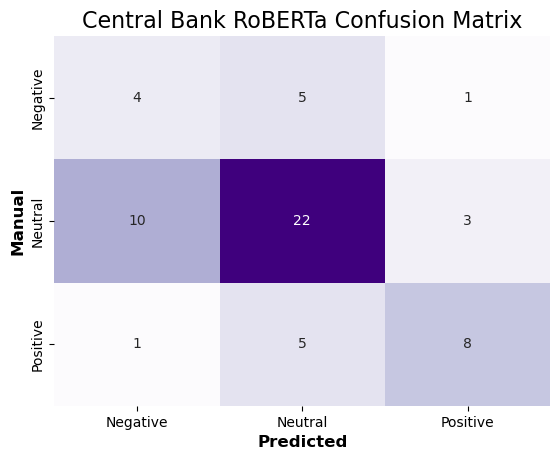

In [558]:
confusion(cbroberta_test, 'cbroberta_label', 'Central Bank RoBERTa', 'cbr_confusion.png')

**Observation:** Better results than LM and FinBERT, mostly coming from identification of 'positive' speeches.

# Chat GPT

In [378]:
# Convert speeches to list
text_list = df['text'].dropna().tolist()

**Note:** API key removed below

In [379]:
# Set your API key
# client = openai.OpenAI(api_key='tk')

In [380]:
# List available models
models = client.models.list()
for model in models.data:
    print(model.id)

gpt-4o-realtime-preview-2024-12-17
gpt-4o-audio-preview-2024-12-17
gpt-4-1106-preview
dall-e-3
dall-e-2
gpt-4o-audio-preview-2024-10-01
gpt-4-turbo-preview
text-embedding-3-small
babbage-002
gpt-4
text-embedding-ada-002
chatgpt-4o-latest
gpt-4o-mini-audio-preview
gpt-4o-audio-preview
gpt-4o-mini-realtime-preview
gpt-4o-mini-realtime-preview-2024-12-17
gpt-4.1-nano
gpt-3.5-turbo-instruct-0914
gpt-4o-mini-search-preview
gpt-4.1-nano-2025-04-14
gpt-3.5-turbo-16k
gpt-4o-realtime-preview
davinci-002
gpt-3.5-turbo-1106
gpt-4o-search-preview
gpt-3.5-turbo-instruct
gpt-3.5-turbo
o3-mini-2025-01-31
gpt-4o-mini-search-preview-2025-03-11
gpt-4-0125-preview
gpt-4o-2024-11-20
gpt-4o-2024-05-13
text-embedding-3-large
o1-2024-12-17
o1
gpt-4-0613
o1-mini
gpt-4o-mini-tts
o1-pro
gpt-4o-transcribe
gpt-4.5-preview
o1-pro-2025-03-19
gpt-4.5-preview-2025-02-27
gpt-4o-search-preview-2025-03-11
omni-moderation-2024-09-26
gpt-image-1
o1-mini-2024-09-12
tts-1-hd
gpt-4o
tts-1-hd-1106
gpt-4o-2024-08-06
gpt-4o-min

In [381]:
# Function to get sentiment
def get_sentiment(speech_text):
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",  
            messages=[
                {"role": "system", "content": "You are a helpful assistant that performs sentiment analysis on central-bank communications."},
                {"role": "user", "content": f"Analyse the overall sentiment of this Bank of England speech. Consider the tone and outlook expressed by the speaker. Respond with only one word: Positive, Neutral, or Negative.\n\nSpeech: {speech_text}"}
            ],
            temperature=0.2,
            max_tokens=10  # Since we only want one word
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"Error processing text: {e}")
        return "Error"

# Process each speech
sentiments = []
for i, speech in enumerate(text_list):
    print(f"Processing speech {i+1}/{len(text_list)}")
    sentiment = get_sentiment(speech)
    sentiments.append(sentiment)
    time.sleep(1)  # Rate limiting to avoid API limits

# Create results dataframe
results_df = pd.DataFrame({
    'Speech_Text': text_list, 
    'Sentiment': sentiments
})

# Save results
results_df.to_csv("boe_sentiment_output.csv", index=False)
print("Analysis complete! Results saved to boe_sentiment_output.csv")

Processing speech 1/59
Processing speech 2/59
Processing speech 3/59
Processing speech 4/59
Processing speech 5/59
Processing speech 6/59
Processing speech 7/59
Processing speech 8/59
Processing speech 9/59
Processing speech 10/59
Processing speech 11/59
Processing speech 12/59
Processing speech 13/59
Processing speech 14/59
Processing speech 15/59
Processing speech 16/59
Processing speech 17/59
Processing speech 18/59
Processing speech 19/59
Processing speech 20/59
Processing speech 21/59
Processing speech 22/59
Processing speech 23/59
Processing speech 24/59
Processing speech 25/59
Processing speech 26/59
Processing speech 27/59
Processing speech 28/59
Processing speech 29/59
Processing speech 30/59
Processing speech 31/59
Processing speech 32/59
Processing speech 33/59
Processing speech 34/59
Processing speech 35/59
Processing speech 36/59
Processing speech 37/59
Processing speech 38/59
Processing speech 39/59
Processing speech 40/59
Processing speech 41/59
Processing speech 42/59
P

In [382]:
# Read in df
boe_test = pd.read_csv('boe_sentiment_output.csv')
# Rename columns
boe_test.columns = ['text', 'gpt_sentiment']

boe_test.tail()

,text,gpt_sentiment
54,Thank you very much to the BBA for inviting me...,Neutral
55,Tony Wilson for their assistance in preparatio...,Neutral
56,It is a pleasure to be able to speak to the So...,Positive
57,My Business here is Study in which I have been...,Positive
58,It is a great pleasure to be here in New York....,Neutral


In [383]:
# Merge GPT results with test data
test_data = test_data.merge(boe_test, on='text')
test_data.head()

,unique_id,sentiment_labelled,text,clean_text,tokens,simple_clean,tb_score,tb_label,neg,neu,...,lm_n_negative,lm_n_positive,sentiment_ratio,lm_label,finbert_pos,finbert_neg,finbert_neu,finbert_sentiment,finbert_score,gpt_sentiment
0,1086,Neutral,It's a pleasure to be speaking once again at t...,pleasure speaking society professional economi...,"[pleasure, speaking, society, professional, ec...",It is a pleasure to be speaking once again at ...,0.125389,Positive,0.074,0.825,...,83,47,-0.276923,Neutral,0.117611,0.422626,0.459763,Neutral,-0.305015,Neutral
1,932,Neutral,Thanks for the invitation. I know many of my c...,thanks invitation know many colleagues previou...,"[thanks, invitation, know, many, colleagues, p...",Thanks for the invitation. I know many of my c...,0.085038,Positive,0.083,0.825,...,83,48,-0.267176,Neutral,0.034042,0.086137,0.879821,Neutral,-0.052094,Neutral
2,278,Positive,"When I took on this job last year, interest ra...",took job last year interest rates moved twice ...,"[took, job, last, year, interest, rates, moved...","When I took on this job last year, interest ra...",0.046656,Positive,0.070,0.804,...,94,72,-0.132530,Neutral,0.175209,0.196836,0.627955,Neutral,-0.021627,Neutral
3,901,Neutral,Resolution has come a long way since G20 Leade...,resolution come long way since g20 leaders put...,"[resolution, come, long, way, since, g20, lead...",Resolution has come a long way since G20 Leade...,0.076115,Positive,0.066,0.835,...,88,21,-0.614679,Negative,0.176402,0.026469,0.797129,Neutral,0.149934,Positive
4,939,Positive,It is a great pleasure to join the Great Exhib...,great pleasure join great exhibition north sma...,"[great, pleasure, join, great, exhibition, nor...",It is a great pleasure to join the Great Exhib...,0.083778,Positive,0.062,0.811,...,53,81,0.208955,Positive,0.089393,0.021921,0.888686,Neutral,0.067473,Positive


## Chat GPT accuracy

In [385]:
metrics(test_data, 'gpt_sentiment', 'Chat GPT')

Chat GPT Results:

Predicted Sentiment Breakdown:
gpt_sentiment
Neutral     66.10%
Positive    20.34%
Negative    13.56%
Name: proportion, dtype: object

--------------------------------------------------

Metrics:
Accuracy: 64.41%
Precision: 63.24%
Recall: 64.41%
F1-Score: 63.54%

--------------------------------------------------



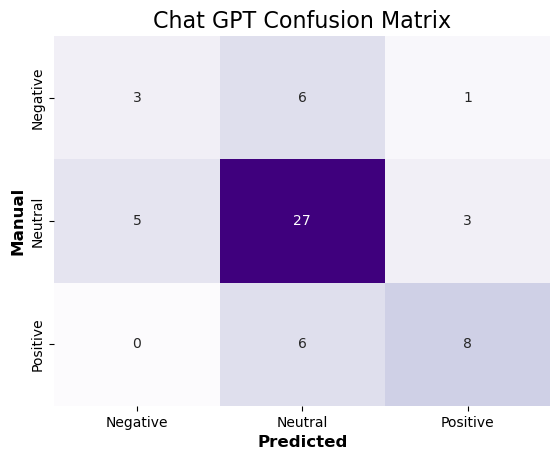

In [556]:
confusion(test_data, 'gpt_sentiment', 'Chat GPT', 'chatgpt_confusion.png')

**Observation:** Chat GPT performs slightly better than CB RoBERTa, mostly coming from its correct identification of neutral speeches. CBRoBERTa has a more negative skew.

# Claude

**Note:** API key removed below

In [514]:
# Set API key
# client = anthropic.Anthropic(api_key="tk")

In [390]:
def get_sentiment(speech_text):
    try:
        response = client.messages.create(
            model="claude-3-haiku-20240307",  # Cheapest option
            max_tokens=10,
            messages=[
                {
                    "role": "user", 
                    "content": f"You are a helpful assistant that performs sentiment analysis on central-bank communications. Analyse the overall sentiment of this Bank of England speech. Consider the tone and outlook expressed by the speaker. Respond with only one word: Positive, Neutral, or Negative.\n\nSpeech: {speech_text}"
                }
            ],
            temperature=0.2
        )
        return response.content[0].text.strip()
    except Exception as e:
        print(f"Error processing text: {e}")
        return "Error"

# Process each speech
sentiments = []
for i, speech in enumerate(text_list):
    print(f"Processing speech {i+1}/{len(text_list)}")
    sentiment = get_sentiment(speech)
    sentiments.append(sentiment)
    time.sleep(1)  # Rate limiting

# Create results dataframe
results_df = pd.DataFrame({
    'Speech_Text': text_list, 
    'Sentiment': sentiments
})

# Save results
results_df.to_csv("boe_sentiment_claude_output.csv", index=False)
print("Analysis complete! Results saved to boe_sentiment_claude_output.csv")

Processing speech 1/59
Processing speech 2/59
Processing speech 3/59
Processing speech 4/59
Processing speech 5/59
Processing speech 6/59
Processing speech 7/59
Processing speech 8/59
Processing speech 9/59
Processing speech 10/59
Processing speech 11/59
Processing speech 12/59
Processing speech 13/59
Processing speech 14/59
Processing speech 15/59
Processing speech 16/59
Processing speech 17/59
Processing speech 18/59
Processing speech 19/59
Processing speech 20/59
Processing speech 21/59
Processing speech 22/59
Processing speech 23/59
Processing speech 24/59
Processing speech 25/59
Processing speech 26/59
Processing speech 27/59
Processing speech 28/59
Processing speech 29/59
Processing speech 30/59
Processing speech 31/59
Processing speech 32/59
Processing speech 33/59
Processing speech 34/59
Processing speech 35/59
Processing speech 36/59
Processing speech 37/59
Processing speech 38/59
Processing speech 39/59
Processing speech 40/59
Processing speech 41/59
Processing speech 42/59
P

In [391]:
# Read in results
claude_results = pd.read_csv('boe_sentiment_claude_output.csv')
# Rename columns
claude_results.columns = ['text', 'claude_sentiment']

print(claude_results.shape)
claude_results.claude_sentiment.value_counts()

(59, 2)


claude_sentiment
Neutral                                          29
Positive                                         18
Positive.                                         5
Negative                                          4
Neutral.                                          1
Negative.                                         1
Neutral.\n\nThe speech presents a balanced an     1
Name: count, dtype: int64

In [392]:
# Function to clean up value formatting in sentiment col
def clean_claude(sentiment_str):
    sentiment_str = str(sentiment_str).strip().replace('.', '').split('\n')[0].split()[0]
    if sentiment_str.lower().startswith('pos'):
        return 'Positive'
    elif sentiment_str.lower().startswith('neg'):
        return 'Negative'
    elif sentiment_str.lower().startswith('neu'):
        return 'Neutral'
    else:
        return 'Neutral'

In [393]:
# Clean results
claude_results['claude_sentiment_clean'] = claude_results['claude_sentiment'].apply(clean_claude)

# Check results
claude_results.claude_sentiment_clean.value_counts()

claude_sentiment_clean
Neutral     31
Positive    23
Negative     5
Name: count, dtype: int64

In [394]:
# Drop original col
claude_results_clean = claude_results.drop(['claude_sentiment'], axis=1)

In [395]:
# Merge with test data
test_data = test_data.merge(claude_results_clean, on='text')

test_data.head()

,unique_id,sentiment_labelled,text,clean_text,tokens,simple_clean,tb_score,tb_label,neg,neu,...,lm_n_positive,sentiment_ratio,lm_label,finbert_pos,finbert_neg,finbert_neu,finbert_sentiment,finbert_score,gpt_sentiment,claude_sentiment_clean
0,1086,Neutral,It's a pleasure to be speaking once again at t...,pleasure speaking society professional economi...,"[pleasure, speaking, society, professional, ec...",It is a pleasure to be speaking once again at ...,0.125389,Positive,0.074,0.825,...,47,-0.276923,Neutral,0.117611,0.422626,0.459763,Neutral,-0.305015,Neutral,Neutral
1,932,Neutral,Thanks for the invitation. I know many of my c...,thanks invitation know many colleagues previou...,"[thanks, invitation, know, many, colleagues, p...",Thanks for the invitation. I know many of my c...,0.085038,Positive,0.083,0.825,...,48,-0.267176,Neutral,0.034042,0.086137,0.879821,Neutral,-0.052094,Neutral,Positive
2,278,Positive,"When I took on this job last year, interest ra...",took job last year interest rates moved twice ...,"[took, job, last, year, interest, rates, moved...","When I took on this job last year, interest ra...",0.046656,Positive,0.070,0.804,...,72,-0.132530,Neutral,0.175209,0.196836,0.627955,Neutral,-0.021627,Neutral,Neutral
3,901,Neutral,Resolution has come a long way since G20 Leade...,resolution come long way since g20 leaders put...,"[resolution, come, long, way, since, g20, lead...",Resolution has come a long way since G20 Leade...,0.076115,Positive,0.066,0.835,...,21,-0.614679,Negative,0.176402,0.026469,0.797129,Neutral,0.149934,Positive,Positive
4,939,Positive,It is a great pleasure to join the Great Exhib...,great pleasure join great exhibition north sma...,"[great, pleasure, join, great, exhibition, nor...",It is a great pleasure to join the Great Exhib...,0.083778,Positive,0.062,0.811,...,81,0.208955,Positive,0.089393,0.021921,0.888686,Neutral,0.067473,Positive,Positive


## Claude accuracy

In [397]:
metrics(test_data, 'claude_sentiment_clean', 'Claude')

Claude Results:

Predicted Sentiment Breakdown:
claude_sentiment_clean
Neutral     52.54%
Positive    38.98%
Negative     8.47%
Name: proportion, dtype: object

--------------------------------------------------

Metrics:
Accuracy: 49.15%
Precision: 49.03%
Recall: 49.15%
F1-Score: 47.96%

--------------------------------------------------



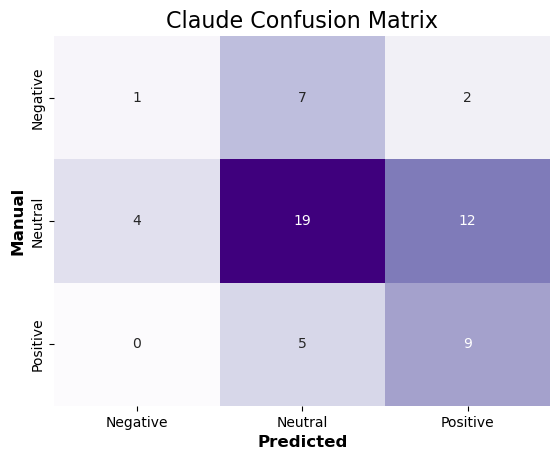

In [585]:
confusion(test_data, 'claude_sentiment_clean', 'Claude')

**Observation:** Claude performs less well than CBRoBERTa and Chat GPT, and the model can be disregarded.

# Conclusions

In [507]:
# List of model columns 
model_columns = ['tb_label', 'vader_label', 'lm_label', 
                 'finbert_sentiment', 'gpt_sentiment', 'claude_sentiment_clean']  
# Replace with your actual column names

# Create empty DataFrame for results
results = pd.DataFrame(
    index=model_columns,
    columns=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

# Calculate metrics for main test data frame
for model in model_columns:
    results.loc[model, 'Accuracy'] = accuracy_score(
        test_data['sentiment_labelled'], test_data[model])
    
    results.loc[model, 'Precision'] = precision_score(
        test_data['sentiment_labelled'], test_data[model], 
        average='weighted', zero_division=0)
    
    results.loc[model, 'Recall'] = recall_score(
        test_data['sentiment_labelled'], test_data[model], 
        average='weighted', zero_division=0)
    
    results.loc[model, 'F1-Score'] = f1_score(
        test_data['sentiment_labelled'], test_data[model], 
        average='weighted', zero_division=0)

# Add in CBRoBERTa
results.loc['cbroberta_label', 'Accuracy'] = accuracy_score(
    cbroberta_test['sentiment_labelled'], cbroberta_test['cbroberta_label'])

results.loc['cbroberta_label', 'Precision'] = precision_score(
    cbroberta_test['sentiment_labelled'], cbroberta_test['cbroberta_label'], 
    average='weighted', zero_division=0)

results.loc['cbroberta_label', 'Recall'] = recall_score(
    cbroberta_test['sentiment_labelled'], cbroberta_test['cbroberta_label'], 
    average='weighted', zero_division=0)

results.loc['cbroberta_label', 'F1-Score'] = f1_score(
    cbroberta_test['sentiment_labelled'], cbroberta_test['cbroberta_label'], 
    average='weighted', zero_division=0)

# Format as percentages
results_formatted = results.map(lambda x: f"{x:.2%}")

# Display the comparison matrix
print("Sentiment Model Comparison:")
print(results_formatted)

# Find best model for each metric
best_models = results.idxmax()
print("\nBest model for each metric:")
for metric, model in best_models.items():
    value = results_formatted.loc[model, metric]
    print(f"{metric}: {model} ({value})")

Sentiment Model Comparison:
                       Accuracy Precision  Recall F1-Score
tb_label                 23.73%     5.63%  23.73%    9.10%
vader_label              23.73%     6.27%  23.73%    9.92%
lm_label                 47.46%    52.00%  47.46%   49.53%
finbert_sentiment        49.15%    46.84%  49.15%   45.48%
gpt_sentiment            64.41%    63.24%  64.41%   63.54%
claude_sentiment_clean   49.15%    49.03%  49.15%   47.96%
cbroberta_label          57.63%    61.12%  57.63%   58.98%

Best model for each metric:
Accuracy: gpt_sentiment (64.41%)
Precision: gpt_sentiment (63.24%)
Recall: gpt_sentiment (64.41%)
F1-Score: gpt_sentiment (63.54%)


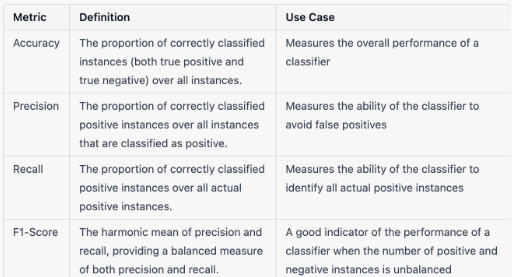